# Analysis by Michał Heit EAD PROJECT

In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

Load data and drop column 'Unnamed: 0' which is only indexing.
We can drop Epoch types because when we have dates, hours in normal readable type.
NOTE: WEATHER DATA FROM DAYTON IS PER DAY

In [189]:
dayton_df = pd.read_csv('./datasets/dayton.csv')

epoch_columns = ['Unnamed: 0', 'datetimeEpoch', 'sunriseEpoch', 'sunsetEpoch']
dayton_df.drop(epoch_columns, axis=1, inplace=True)

dayton_df['datetime'] = pd.to_datetime(dayton_df['datetime'])
dayton_df.set_index('datetime', inplace=True)

Load electrical consumption from dayton
NOTE: ELECTRICAL CONSUMPTION IS PER HOUR

In [190]:
electrical_cons_dayton_df = pd.read_csv('./datasets/Energy_consumption_Dayton.csv')
electrical_cons_dayton_df['Datetime'] = pd.to_datetime(electrical_cons_dayton_df['Datetime'])

original_e_cons_df = electrical_cons_dayton_df.copy()

Make electrical consumption per day by using groupby and do it with function mean

In [191]:
electrical_cons_dayton_df = electrical_cons_dayton_df.set_index('Datetime').groupby(pd.Grouper(freq='d')).mean()

Let's concatenate electrical and weather df for analyzing

In [192]:
complete_df = pd.concat([electrical_cons_dayton_df, dayton_df], axis=1, join='inner')

First look on dataset, I can see a lot of NaNs in some columns

In [193]:
complete_df

,Energy_MW,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,uvindex,sunrise,sunset,moonphase,conditions,description,icon,stations,source,tzoffset
2004-10-01,1924.130435,24.0,6.3,15.4,24.0,5.1,15.4,9.9,73.05,0.60,...,0.0,07:33:19,19:18:34,0.55,"Rain, Partially cloudy",Partly cloudy throughout the day with rain cle...,rain,"['74570099999', '72429613841', '72427699999', ...",obs,NaN
2004-10-02,1641.583333,18.3,8.1,15.4,18.3,7.6,15.3,9.7,72.24,1.85,...,0.0,07:34:17,19:16:58,0.58,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"['74570099999', '72429613841', '72427699999', ...",obs,NaN
2004-10-03,1528.708333,19.7,1.9,10.5,19.7,1.9,10.5,2.0,61.99,0.00,...,0.0,07:35:16,19:15:21,0.62,Clear,Clear conditions throughout the day.,clear-day,"['74570099999', '72429613841', '72427699999', ...",obs,NaN
2004-10-04,1926.541667,18.5,7.6,12.7,18.5,6.3,12.2,3.3,54.33,0.00,...,0.0,07:36:15,19:13:46,0.67,Clear,Clear conditions throughout the day.,clear-day,"['74570099999', '72429613841', '72427699999', ...",obs,NaN
2004-10-05,1970.125000,16.1,0.9,9.1,16.1,-1.2,8.4,0.8,59.85,0.00,...,0.0,07:37:15,19:12:11,0.71,Clear,Clear conditions throughout the day.,clear-day,"['74570099999', '72429613841', '72427699999', ...",obs,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-30,2026.333333,24.6,18.3,21.2,24.6,18.3,21.2,17.7,81.14,1.20,...,5.0,06:33:56,20:51:55,0.53,"Rain, Overcast",Cloudy skies throughout the day with rain clea...,rain,"['72429093815', 'KDAY', '74570013840', 'KFFO',...",obs,NaN
2018-07-31,2051.083333,25.5,19.4,21.5,25.5,19.4,21.5,19.2,87.07,20.45,...,4.0,06:34:50,20:50:55,0.56,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"['72429093815', 'KDAY', '74570013840', 'KFFO',...",obs,NaN
2018-08-01,2060.291667,25.4,19.0,21.4,25.4,19.0,21.4,18.0,81.79,0.00,...,4.0,06:35:45,20:49:52,0.60,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['72429093815', 'KDAY', '74570013840', 'KFFO',...",obs,NaN
2018-08-02,2168.208333,26.6,18.4,22.7,26.6,18.4,22.7,18.4,78.35,0.00,...,7.0,06:36:40,20:48:48,0.64,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['72429093815', 'KDAY', '74570013840', 'KFFO',...",obs,NaN


let's check the percent of nans in columns

In [194]:
missing_columns = complete_df.isnull().sum() / len(complete_df.index) * 100

Missing columns:
* precipprob
* preciptype
* snow
* snowdepth
* windgust
* winddir
* solarradation
* solarenergy
* tzoffset

All of them are mostly empty expect winddir but I don't really think it has some influence on energy. Let's drop these variables.

In [195]:
missing_columns = missing_columns[(missing_columns > 0)]

In [196]:
missing_columns

precipprob        100.000000
preciptype        100.000000
snow               78.654797
snowdepth          71.097923
windgust           46.726014
winddir            14.421365
solarradiation     98.516320
solarenergy        98.516320
tzoffset           48.941642
dtype: float64

In [197]:
complete_df.drop(list(missing_columns.index), inplace=True, axis=1)

I decide to drop description too because we have almost the same information from icon column and it's better to categorize.
To be honest source and stations don't see to give some value to model.

In [198]:
complete_df.drop(['description', 'stations', 'source'], inplace=True, axis=1)

In [199]:
complete_df

,Energy_MW,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,windspeed,pressure,cloudcover,visibility,uvindex,sunrise,sunset,moonphase,conditions,icon
2004-10-01,1924.130435,24.0,6.3,15.4,24.0,5.1,15.4,9.9,73.05,0.60,...,20.4,1019.1,35.9,12.1,0.0,07:33:19,19:18:34,0.55,"Rain, Partially cloudy",rain
2004-10-02,1641.583333,18.3,8.1,15.4,18.3,7.6,15.3,9.7,72.24,1.85,...,24.4,1020.3,61.4,11.8,0.0,07:34:17,19:16:58,0.58,"Rain, Partially cloudy",rain
2004-10-03,1528.708333,19.7,1.9,10.5,19.7,1.9,10.5,2.0,61.99,0.00,...,15.0,1023.9,4.7,13.0,0.0,07:35:16,19:15:21,0.62,Clear,clear-day
2004-10-04,1926.541667,18.5,7.6,12.7,18.5,6.3,12.2,3.3,54.33,0.00,...,21.6,1020.6,10.6,13.0,0.0,07:36:15,19:13:46,0.67,Clear,clear-day
2004-10-05,1970.125000,16.1,0.9,9.1,16.1,-1.2,8.4,0.8,59.85,0.00,...,10.2,1028.5,3.0,12.9,0.0,07:37:15,19:12:11,0.71,Clear,clear-day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-30,2026.333333,24.6,18.3,21.2,24.6,18.3,21.2,17.7,81.14,1.20,...,17.6,1017.8,91.6,15.8,5.0,06:33:56,20:51:55,0.53,"Rain, Overcast",rain
2018-07-31,2051.083333,25.5,19.4,21.5,25.5,19.4,21.5,19.2,87.07,20.45,...,16.0,1013.9,84.9,13.3,4.0,06:34:50,20:50:55,0.56,"Rain, Partially cloudy",rain
2018-08-01,2060.291667,25.4,19.0,21.4,25.4,19.0,21.4,18.0,81.79,0.00,...,13.8,1015.2,83.4,15.6,4.0,06:35:45,20:49:52,0.60,Partially cloudy,partly-cloudy-day
2018-08-02,2168.208333,26.6,18.4,22.7,26.6,18.4,22.7,18.4,78.35,0.00,...,13.5,1017.6,47.6,13.4,7.0,06:36:40,20:48:48,0.64,Partially cloudy,partly-cloudy-day


Distribution of variable that I want to predict, We can see a periodic trend. Probably the energy depends on seasons.

<AxesSubplot:xlabel='Lata', ylabel='Energia'>

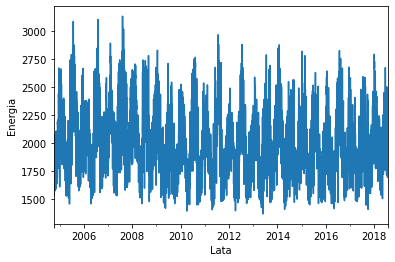

In [200]:
complete_df['Energy_MW'].plot(xlabel='Lata', ylabel='Energia')

# PERIODICAL ANALYSIS

Let's check the energy in particular seasons

([<matplotlib.axis.XTick at 0x1e1864d37c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  

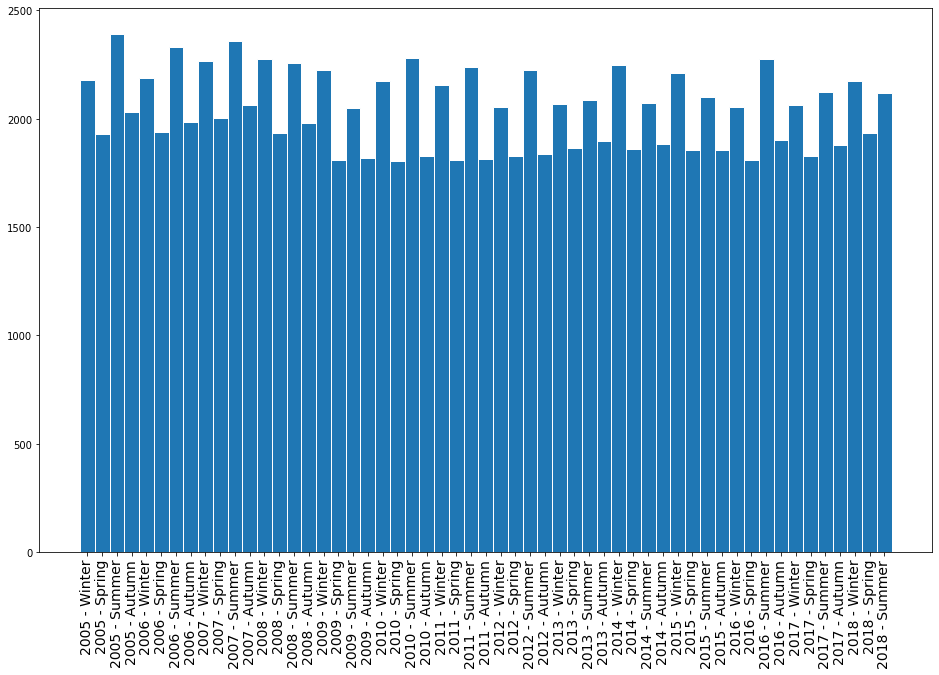

In [201]:
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5:'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}

month_complete_df = complete_df.groupby(pd.Grouper(freq='M')).mean()
month_complete_df = month_complete_df.reset_index().rename(columns={'index': 'daytime'})
month_complete_df.drop([0], inplace=True)
season_df = month_complete_df.set_index('daytime').groupby(pd.Grouper(freq='3m')).mean()
season_df.drop('2004-11-30', inplace=True)

seasons_year_ticks = []
seasons_ticks = []
for date in list(season_df.index):
    tick = str(date.year) + ' - ' + seasons[date.month]
    seasons_year_ticks.append(tick)
    seasons_ticks.append(seasons[date.month])

season_df['season'] = seasons_ticks

plt.figure(figsize=(16, 10))
plt.bar(seasons_year_ticks, season_df['Energy_MW'], width=1, edgecolor='white')
plt.xticks(seasons_year_ticks, rotation='vertical', fontsize='14')

I can see that over all years energy consumption amplitude doesn't change that much. Let's check this with some statistics. In a plot above we can see some peaks in winter and summer.

In [202]:
season_df.groupby(pd.Grouper(freq='Y')).mean().describe()['Energy_MW']

count      14.000000
mean     2040.559604
std        66.419354
min      1972.521981
25%      1990.179469
50%      2013.356437
75%      2101.037024
max      2172.958906
Name: Energy_MW, dtype: float64

 I added a new feature 'season' let's groupby seasons and see the mean diff.

<BarContainer object of 4 artists>

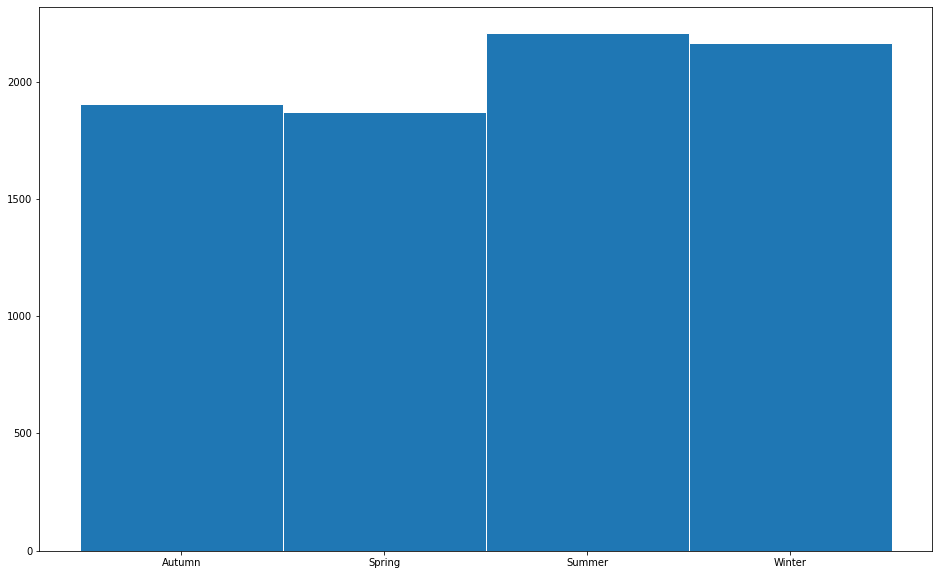

In [203]:
temp_df_to_plot = season_df.reset_index().groupby('season').mean()
plt.figure(figsize=(16, 10))
plt.bar(temp_df_to_plot.index, temp_df_to_plot['Energy_MW'], width=1, edgecolor='white')

**So we know that seasons matters** Let's analyze deeper, parts of the day

C:\Users\micha\AppData\Local\Temp\ipykernel_7520\1594841208.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(list(parts_day_df.index), fontsize='14')
C:\Users\micha\AppData\Local\Temp\ipykernel_7520\1594841208.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(list(combined_day_df.index), rotation='vertical', fontsize='14')


[Text(0, 0, 'FridayEvening'),
 Text(1, 0, 'FridayMorning'),
 Text(2, 0, 'FridayNight'),
 Text(3, 0, 'FridayNoon'),
 Text(4, 0, 'MondayEvening'),
 Text(5, 0, 'MondayMorning'),
 Text(6, 0, 'MondayNight'),
 Text(7, 0, 'MondayNoon'),
 Text(8, 0, 'SaturdayEvening'),
 Text(9, 0, 'SaturdayMorning'),
 Text(10, 0, 'SaturdayNight'),
 Text(11, 0, 'SaturdayNoon'),
 Text(12, 0, 'SundayEvening'),
 Text(13, 0, 'SundayMorning'),
 Text(14, 0, 'SundayNight'),
 Text(15, 0, 'SundayNoon'),
 Text(16, 0, 'ThursdayEvening'),
 Text(17, 0, 'ThursdayMorning'),
 Text(18, 0, 'ThursdayNight'),
 Text(19, 0, 'ThursdayNoon'),
 Text(20, 0, 'TuesdayEvening'),
 Text(21, 0, 'TuesdayMorning'),
 Text(22, 0, 'TuesdayNight'),
 Text(23, 0, 'TuesdayNoon'),
 Text(24, 0, 'WednesdayEvening'),
 Text(25, 0, 'WednesdayMorning'),
 Text(26, 0, 'WednesdayNight'),
 Text(27, 0, 'WednesdayNoon')]

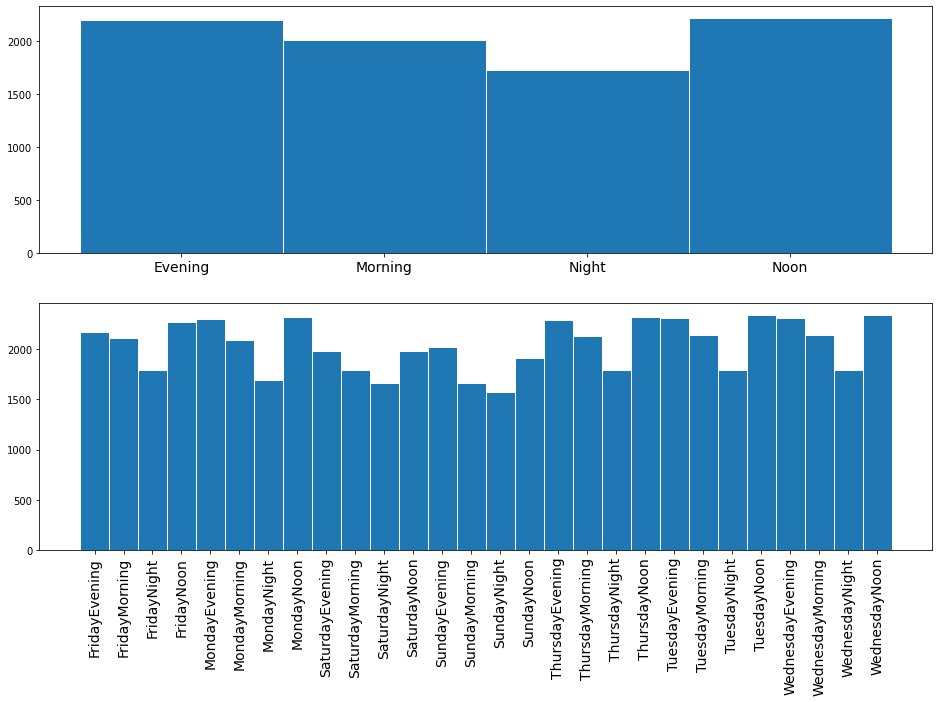

In [268]:
parts_day = {0: 'Night', 6: 'Morning', 12: 'Noon', 18: 'Evening'}

temp_df = original_e_cons_df.groupby(pd.Grouper(freq='6h')).mean()

parts_day_ticks = []
week_day = []
for date in list(temp_df.index):
    parts_day_ticks.append(parts_day[date.hour])
    week_day.append(date.day_name())

temp_df.reset_index(inplace=True)
temp_df.drop('Datetime', inplace=True, axis=1)

temp_df['part_of_day'] = parts_day_ticks
temp_df['week_day'] = week_day
temp_df['combined_day'] = temp_df['week_day'] + temp_df['part_of_day']

combined_day_df = temp_df.groupby('combined_day').mean()
parts_day_df = temp_df.groupby('part_of_day').mean()

fig, axs= plt.subplots(2, figsize=(16, 10))


axs[0].bar(list(parts_day_df.index), parts_day_df['Energy_MW'], width=1, edgecolor='white')
axs[0].set_xticklabels(list(parts_day_df.index), fontsize='14')
axs[1].bar(list(combined_day_df.index), combined_day_df['Energy_MW'], width=1, edgecolor='white')
axs[1].set_xticklabels(list(combined_day_df.index), rotation='vertical', fontsize='14')